# Compressed Sensing - Numerical experiments  
*Badis Jaouani - M2 Stat*

## Article: The troublesome kernel: why deep learning for inverse problems is typically unstable
*Gottschling et al. 2020*
___

In this notebook, numerical experiments are conducted in order to show the robustness of Compressed Sensing methods to noise. These experiments come as an illustration to the theoretical results proved by the article's authors. 

## Table of Contents:
___

1. [Images import, filters construction & noiseless $L_1$ recovery](#ImportImages)
2. [Noisy $L_1$ recovery via Basis Poursuit (Fourier Basis)](#L1)
3. [Noisy $L_1$ recovery via Basis Poursuit (Fourier Wavelet Basis)](#L1)

Let's start by importing the necessary libraries.

In [1]:
import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from IPython.display import display, HTML

from nt_toolbox.general import *
from nt_toolbox.signal import *
from nt_toolbox.optim import *
from nt_toolbox.perform_wavelet_transf import *
from nt_toolbox.compute_wavelet_filter import *

import warnings
warnings.filterwarnings('ignore')

import time as time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

sns.set_style('whitegrid')

# 1. Images import, filters construction & noiseless $L_1$ recovery
___
In this lab, two images are used, the first comes from medical imaging, more precisely MRI Brain Imaging. The second image contatains details that Neural Networks couldn't recover, we will try to recover them using our classical Basis Poursuit procedure.

In [2]:
im = load_image("nt_toolbox/data/brain512.jpg")
imm = load_image("nt_toolbox/data/ellipses.png")
p = im.shape[1]

m = int(np.round(0.3 * p**2))  # Number of measurements

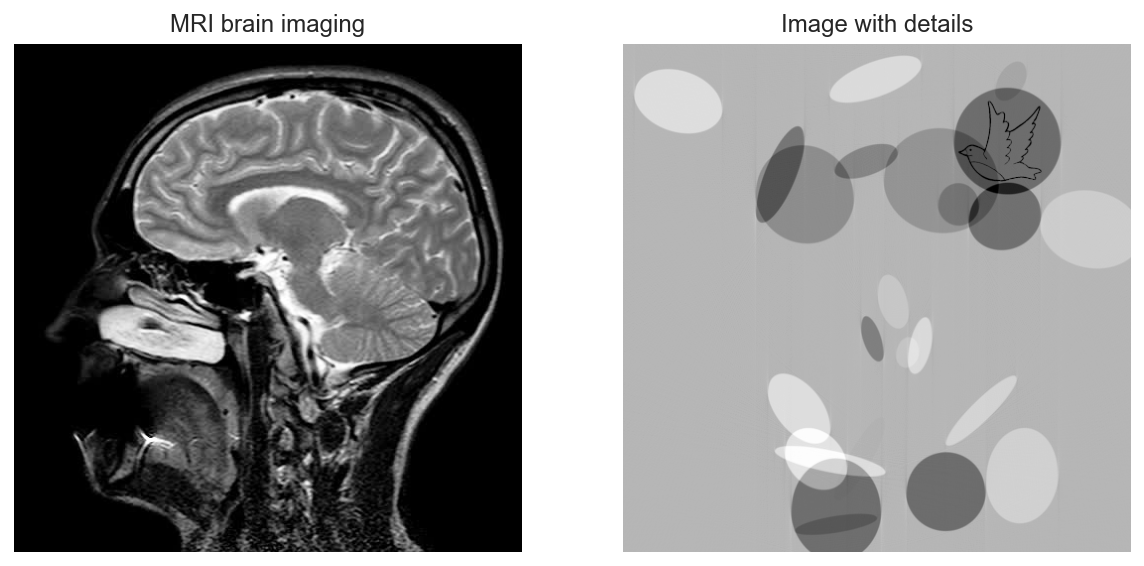

In [3]:
plt.figure(figsize = (10,5))

plt.subplot(121)
plt.imshow(im, cmap = 'Greys_r')
plt.title('MRI brain imaging')
plt.axis('off');

plt.subplot(122)
plt.imshow(imm, cmap = 'Greys_r')
plt.title('Image with details')
plt.axis('off');

We now compute the Fourier transform for both images, and construct three filters from which we will choose one for the upcoming experiments. The three filters are seen during the labs:
- **Filter 1**: all the elements are equal to 1 ie. all the frequencies are taken into consideration.
- **Filter 2**: Non-linear Fourier Transform ie. the M most significant frequencies are kept.
- **Filter 3**: Represented below and used in the previous lab.

We will see in what follows the importance of structure in subsampling.

In [4]:
# Fourier Transform
F, Fm = pyl.fft2(im) / p, pyl.fft2(imm) / p 
mask1 = pyl.fftshift(np.ones_like(np.abs(F)))
L1, L1m = mask1 * F, mask1 * Fm

# Find the threshold that keeps the most M significant Fourier Coefs
M = int(p**2 / 3.33)
F_sorted, F_sortedm = np.sort(np.abs(F).reshape(-1,))[::-1], np.sort(np.abs(Fm).reshape(-1,))[::-1]
thd, thd_m = F_sorted[M], F_sortedm[M]

# Set the other coefs to 0
F1, F1m = F.copy(), Fm.copy()
F1[np.abs(F) <= thd], F1m[np.abs(Fm) <= thd_m] = 0, 0

# Compute mask for non linear Fourier Transform
mask2, mask2m = np.zeros(F1.shape), np.zeros(F1m.shape)
mask2[np.abs(F1) != 0], mask2m[np.abs(F1m) != 0] = 1, 1
mask2, mask2m = pyl.fftshift(mask2), pyl.fftshift(mask2m)

# Compute the Log(Fourier Transform)
L2, L2m = mask2 * F, mask2m * Fm

# Compute third mask
mask3 = loadmat('nt_toolbox/data/mask512.mat')['mask']
L3, L3m = pyl.fftshift(mask3) * F, pyl.fftshift(mask3) * Fm

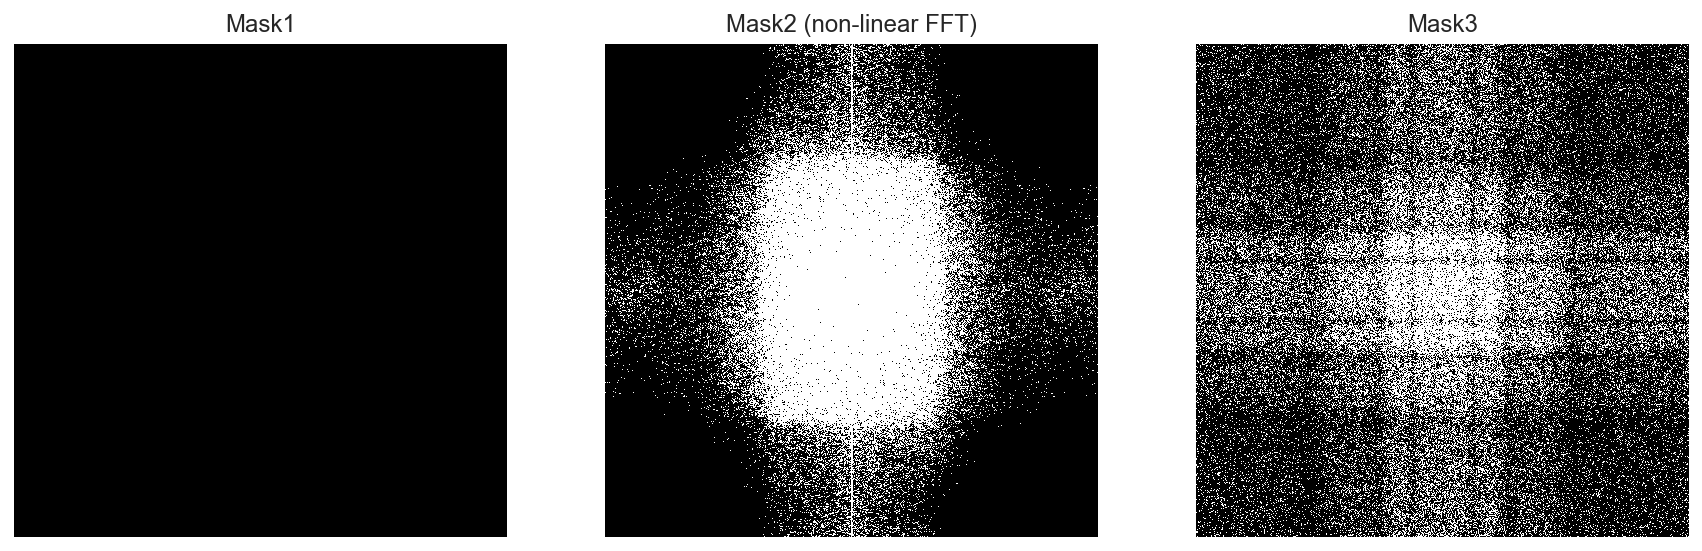

In [5]:
plt.figure(figsize = (15,5))

plt.subplot(131)
imageplot(mask1, 'Mask1')

plt.subplot(132)
imageplot(np.abs(mask2), 'Mask2 (non-linear FFT)')

plt.subplot(133)
imageplot(mask3, 'Mask3')

The second mask takes the M highest Fourier coefficients while the third samples weights from all frequencies. Keep in mind that the fraction of measurements is nearly the same for both masks.

In [6]:
display(HTML(
    f"Ratio of kept coefficients: {mask2[mask2 == 1].real.sum()/mask2.size} <br/>"
))

Let us try to reconstruct, both images are reconstructed via BP & Douglas-Rashford Algorithm.

In [7]:
# L1-reconstruction - MRI
# Execution time of the order of 30s
niter = 150
rec1, lun1, err1, snr1 = MinL1_f_2d(mask1, L1, im, niter=niter)
rec2, lun2, err2, snr2 = MinL1_f_2d(mask2, L2, im, niter=niter)
rec3, lun3, err3, snr3 = MinL1_f_2d(mask3, L3, im, niter=niter)

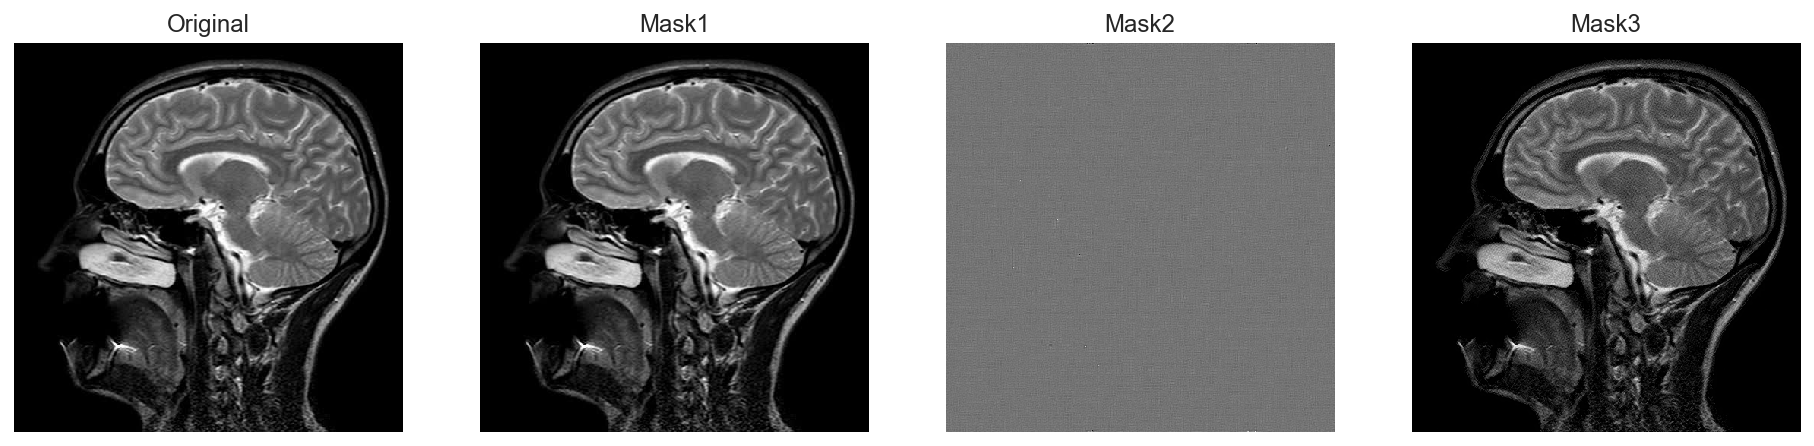

In [8]:
plt.figure(figsize = (16,4))

plt.subplot(141)
imageplot(im, 'Original')

plt.subplot(142)
imageplot(rec1, 'Mask1')

plt.subplot(143)
imageplot(rec2, 'Mask2')

plt.subplot(144)
imageplot(rec3, 'Mask3')

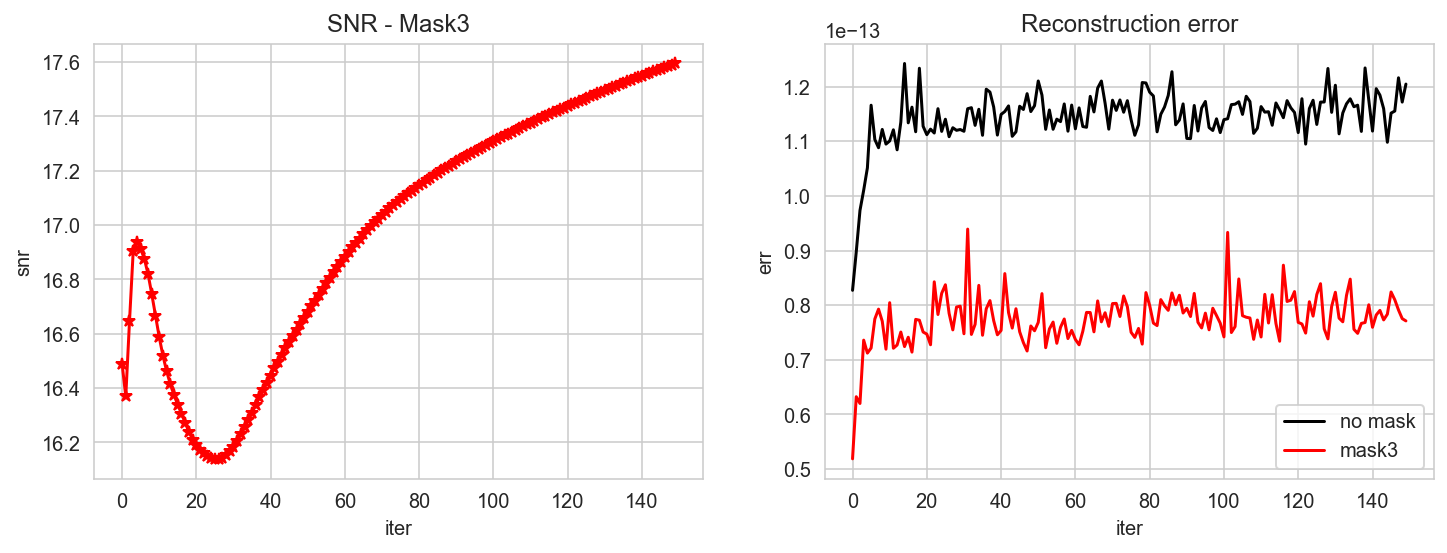

In [9]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(snr3, '-*', color = 'red')
plt.title('SNR - Mask3')
plt.xlabel('iter')
plt.ylabel('snr')

plt.subplot(122)
plt.plot(err1, color = 'black', label = 'no mask')
plt.plot(err3, color = 'red', label = 'mask3')
plt.title('Reconstruction error')
plt.xlabel('iter')
plt.ylabel('err')
plt.legend();

In [10]:
# L1-reconstruction - Second image
# Execution time of the order of 10s
niter = 30
rec1m, lun1m, err1m, snr1m = MinL1_f_2d(mask1, L1m, imm, niter=niter)
rec2m, lun2m, err2m, snr2m = MinL1_f_2d(mask2m, L2m, imm, niter=niter)
rec3m, lun3m, err3m, snr3m = MinL1_f_2d(mask3, L3m, imm, niter=niter)

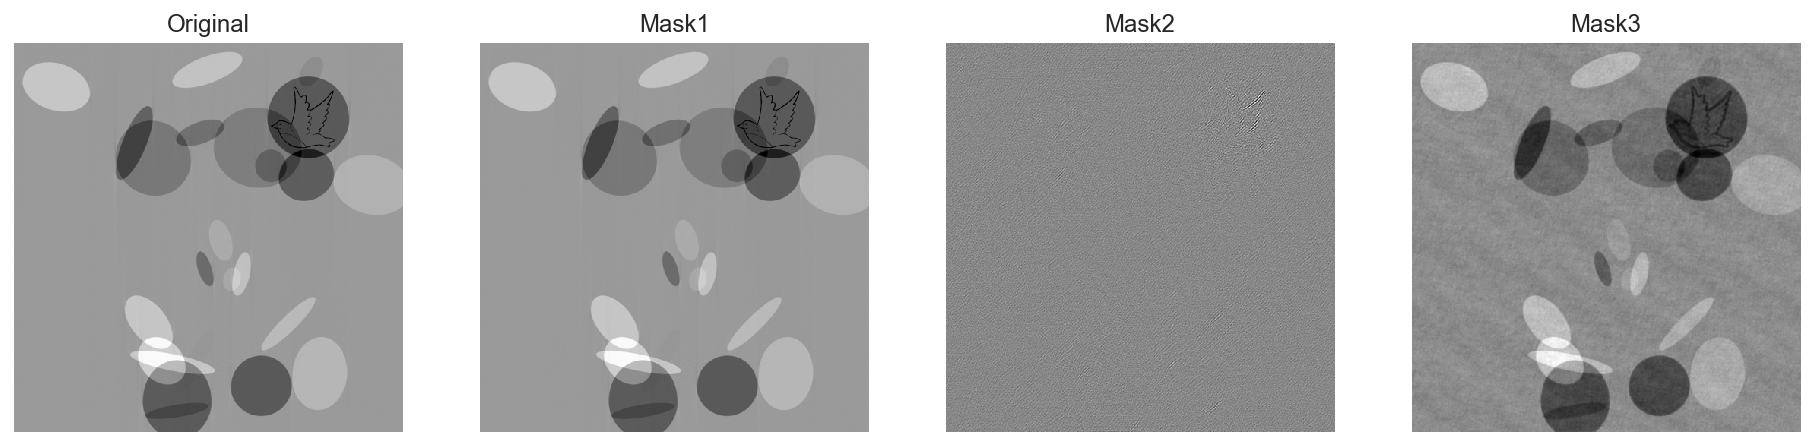

In [11]:
plt.figure(figsize = (16,4))

plt.subplot(141)
imageplot(imm, 'Original')

plt.subplot(142)
imageplot(rec1m, 'Mask1')

plt.subplot(143)
imageplot(rec2m, 'Mask2')

plt.subplot(144)
imageplot(rec3m, 'Mask3')

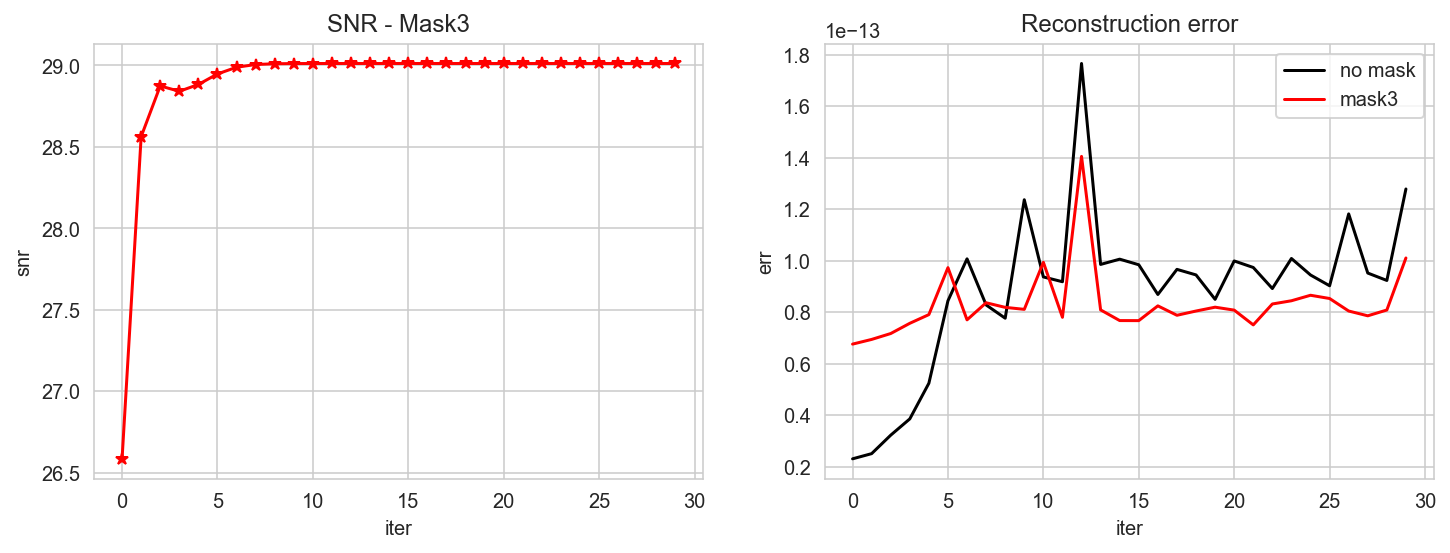

In [12]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(snr3m, '-*', color = 'red')
plt.title('SNR - Mask3')
plt.xlabel('iter')
plt.ylabel('snr')

plt.subplot(122)
plt.plot(err1m, color = 'black', label = 'no mask')
plt.plot(err3m, color = 'red', label = 'mask3')
plt.title('Reconstruction error')
plt.xlabel('iter')
plt.ylabel('err')
plt.legend();

The choice of the mask is then very important. For what is next, all the experiments are conducted with the third mask, which was used for structured measurements in the previous lab.

# 2. Noisy $L_1$ recovery via Basis Poursuit (Fourier Basis)
___
In this section, we use the Fourier Sparsifying transform in order to reconstruct the images. We add gradually increasing noise and see the effect it has on the recovery.

**Note**: To choose the image, change the variable `img_path`
### 2.1) Noise construction & New measurements

In [13]:
img_path = 'nt_toolbox/data/ellipses.png' # brain512.jpg
im = load_image(img_path)

In [14]:
gauss1 = 0.01 * np.random.randn(p,p)
gauss2 = 0.05 * np.random.randn(p,p)
gauss3 = 0.1 * np.random.randn(p,p)

In [15]:
im1 = im + gauss1
im2 = im + gauss2
im3 = im + gauss3

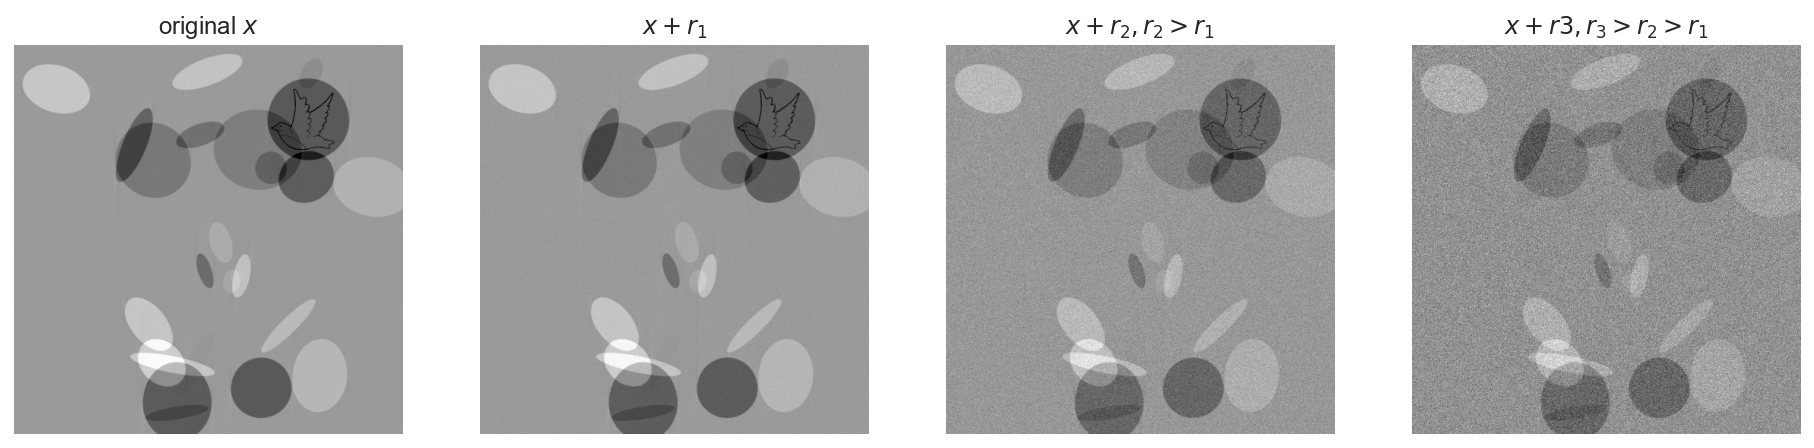

In [16]:
# Graphics
plt.figure(figsize = (16,4))

plt.subplot(141)
plt.imshow(im, cmap = 'gray')
plt.axis('off')
plt.title('original $x$')

plt.subplot(142)
plt.imshow(im1, cmap = 'gray')
plt.axis('off')
plt.title('$x+r_1$')

plt.subplot(143)
plt.imshow(im2, cmap = 'gray')
plt.axis('off')
plt.title(r'$x+r_2, r_2 > r_1$')

plt.subplot(144)
plt.imshow(im3, cmap = 'gray')
plt.axis('off')
plt.title(r'$x+r3, r_3 > r_2 > r_1$');

In [17]:
# Fourier Transform
F0 = pyl.fft2(im) / p
F1 = pyl.fft2(im1) / p
F2 = pyl.fft2(im2) / p
F3 = pyl.fft2(im3) / p

# Compute third mask
mask3 = loadmat('nt_toolbox/data/mask512.mat')['mask']
L03 = pyl.fftshift(mask3) * F0
L31 = pyl.fftshift(mask3) * F1
L32 = pyl.fftshift(mask3) * F2
L33 = pyl.fftshift(mask3) * F3

### 2.2) $\mathcal{L_1}$ Recovery

In [18]:
# Reconstruction (in case of Fourier transform)
niter = 50
rec30, lun30, err30, snr30 = MinL1_f_2d(mask3, L03, im, niter = niter)
rec31, lun31, err31, snr31 = MinL1_f_2d(mask3, L31, im1, niter = niter)
rec32, lun32, err32, snr32 = MinL1_f_2d(mask3, L32, im2, niter = niter)
rec33, lun33, err33, snr33 = MinL1_f_2d(mask3, L33, im3, niter = niter)

(-0.5, 779.5, 777.5, -0.5)

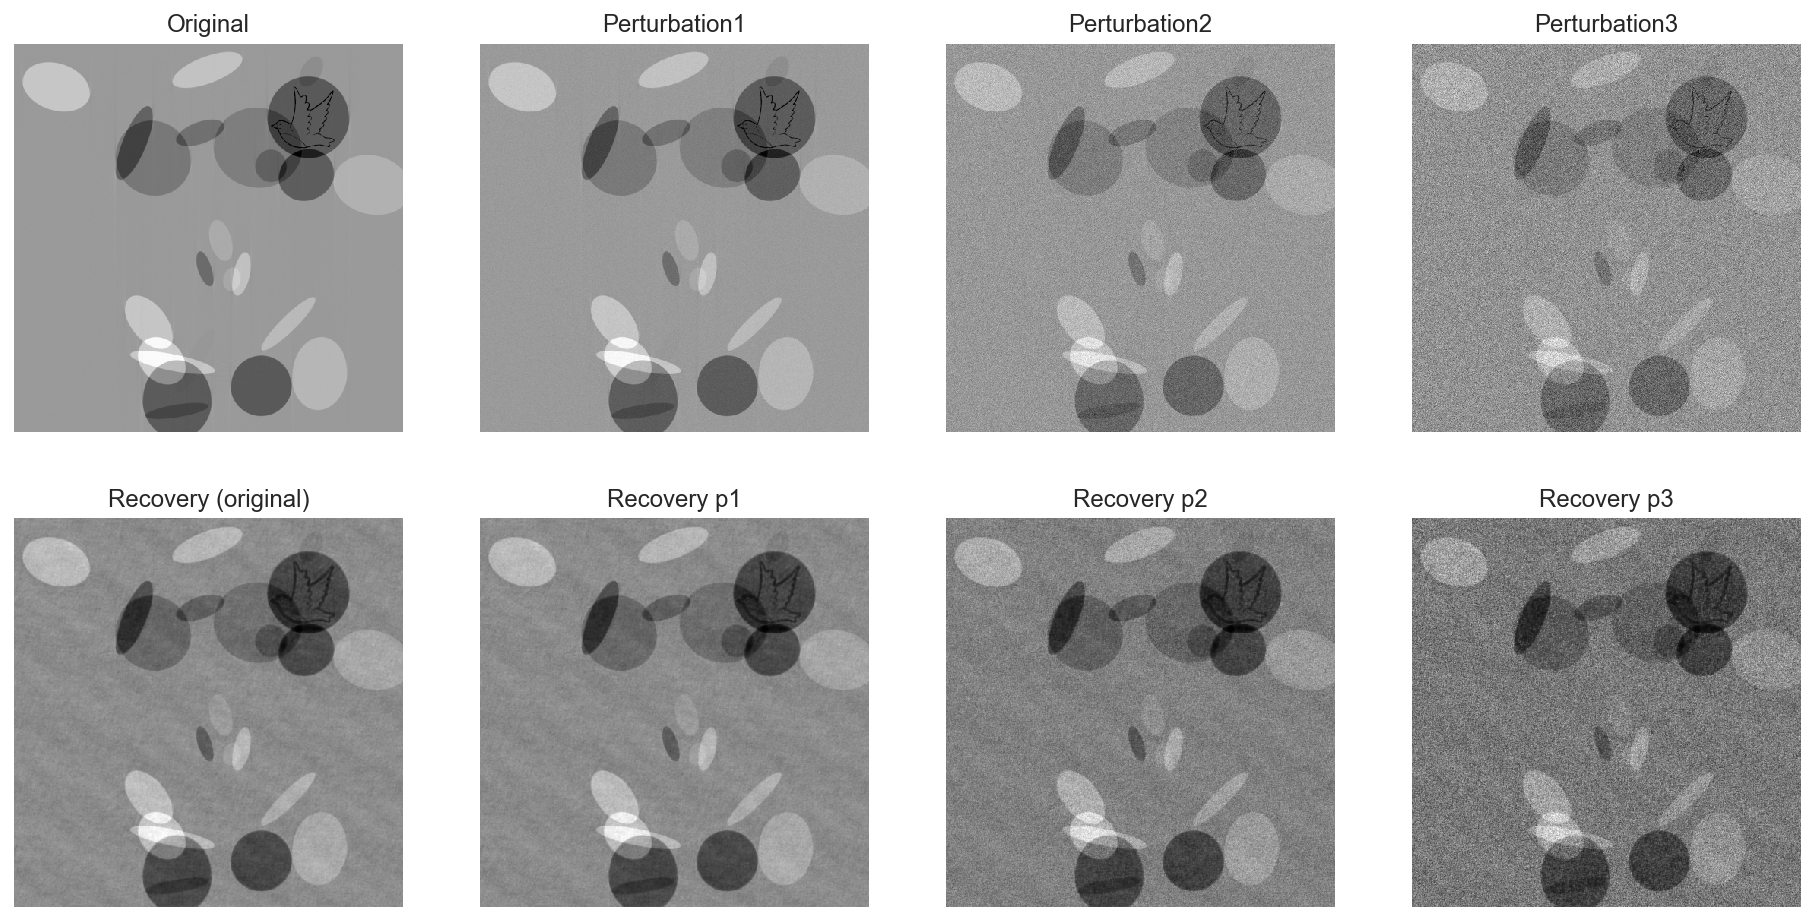

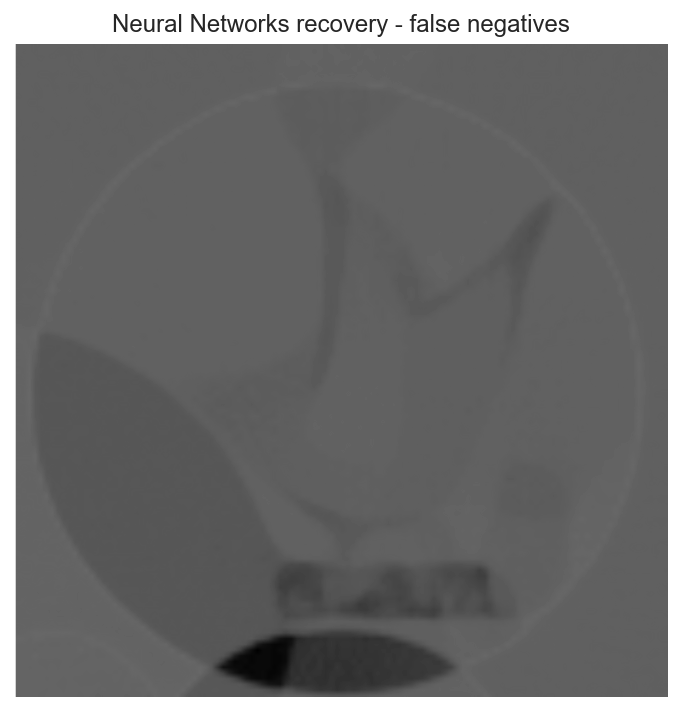

In [19]:
# Graphics
plt.figure(figsize = (16,8))

plt.subplot(241)
imageplot(im, 'Original')

plt.subplot(242)
imageplot(im1, 'Perturbation1')

plt.subplot(243)
imageplot(im2, 'Perturbation2')

plt.subplot(244)
imageplot(im3, 'Perturbation3')

plt.subplot(245)
imageplot(rec30, 'Recovery (original)')

plt.subplot(246)
imageplot(rec31, 'Recovery p1')

plt.subplot(247)
imageplot(rec32, 'Recovery p2')

plt.subplot(248)
imageplot(rec33, 'Recovery p3')

plt.figure(figsize = (6,6))
path = 'nt_toolbox/data/siam.png'
nn = load_image(path)
plt.imshow(nn, cmap = 'gray')
plt.title('Neural Networks recovery - false negatives')
plt.axis('off')

Unlike for Neural Networks, the recovery is less affected by additive noise although it gets more and more difficult for the algorithm to have an exact reconstitution. Most importantly, artefacts are not observed and the details are still visible in the recovered image. In terms of False Positives/Negatives, none of the is introduced neither.

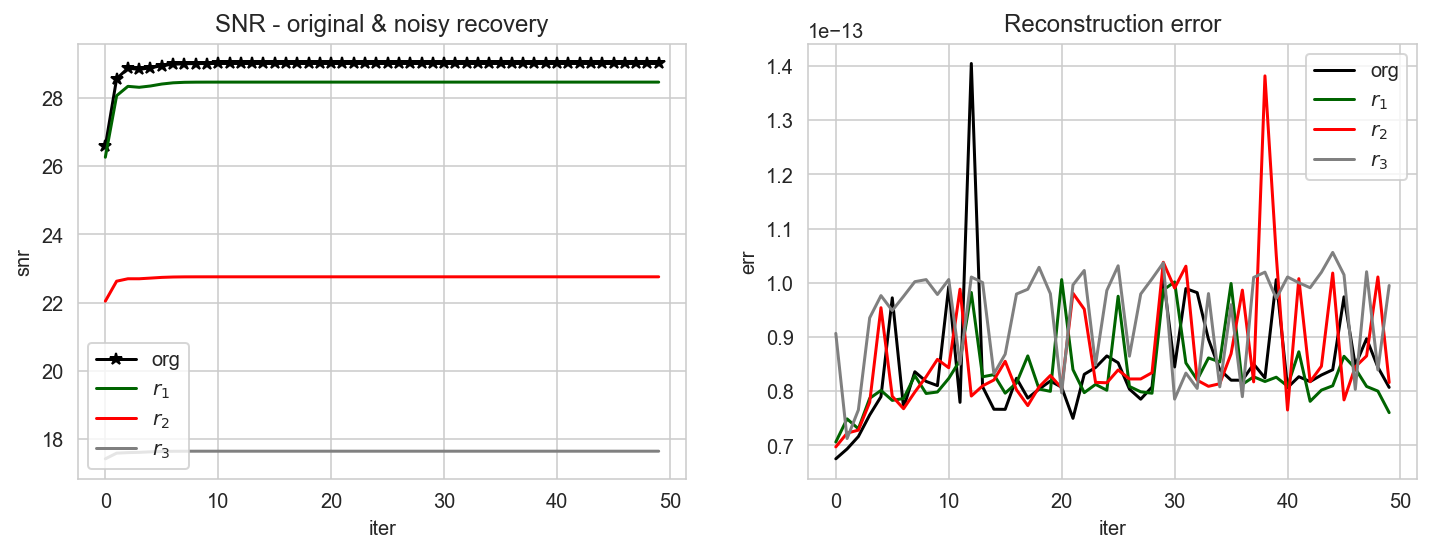

In [20]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(snr30, '-*', color = 'black', label = 'org')
plt.plot(snr31, '-', color = 'darkgreen', label = '$r_1$')
plt.plot(snr32, '-', color = 'red', label = '$r_2$')
plt.plot(snr33, '-', color = 'grey', label = '$r_3$')

plt.title('SNR - original & noisy recovery')
plt.xlabel('iter')
plt.ylabel('snr')
plt.legend()

plt.subplot(122)
plt.plot(err30, '-', color = 'black', label = 'org')
plt.plot(err31, '-', color = 'darkgreen', label = '$r_1$')
plt.plot(err32, '-', color = 'red', label = '$r_2$')
plt.plot(err33, '-', color = 'grey', label = '$r_3$')
plt.title('Reconstruction error')
plt.xlabel('iter')
plt.ylabel('err')
plt.legend();

With little noise, the psnr is very close to the noiseless recovery. The error is still very low between the sparse representation and the recoverded signal, highlighting the recovery of Basis Poursuit procedure. Let us now see if a change in the representation basis affects the results.

# 3. Noisy $L_1$ recovery via Basis Poursuit (Fourier Wavelets Basis)
___


The parameters for the wavelets basis are the following: 
- Daubechies
- Par = $k$ where $k$ is a parameter related to the support and vanishing moments of the wavelets, explained below for each wavelet

In [21]:
# Parameters for the wavelets filter
d = 2
level = 3
J = np.log2(p)
Jmin = max(1, J-level)
hparams = ('Daubechies', 10)

In [22]:
# Reconstruction (in case of Fourier Wavelets transform)
niter = 30
rec30, lun30, err30, snr30 = MinL1_fw_2d(mask3, L03, level, im, hparams = hparams, niter = niter)
rec31, lun31, err31, snr31 = MinL1_fw_2d(mask3, L31, level, im1, hparams = hparams, niter = niter)
rec32, lun32, err32, snr32 = MinL1_fw_2d(mask3, L32, level, im2, hparams = hparams, niter = niter)
rec33, lun33, err33, snr33 = MinL1_fw_2d(mask3, L33, level, im3, hparams = hparams, niter = niter)

In [23]:
# Reconstruction (for wavelets)
h = compute_wavelet_filter(*hparams)
rec_trans30 = perform_wavortho_transf(rec30, Jmin, -1, h)
rec_trans31 = perform_wavortho_transf(rec31, Jmin, -1, h)
rec_trans32 = perform_wavortho_transf(rec32, Jmin, -1, h)
rec_trans33 = perform_wavortho_transf(rec33, Jmin, -1, h)

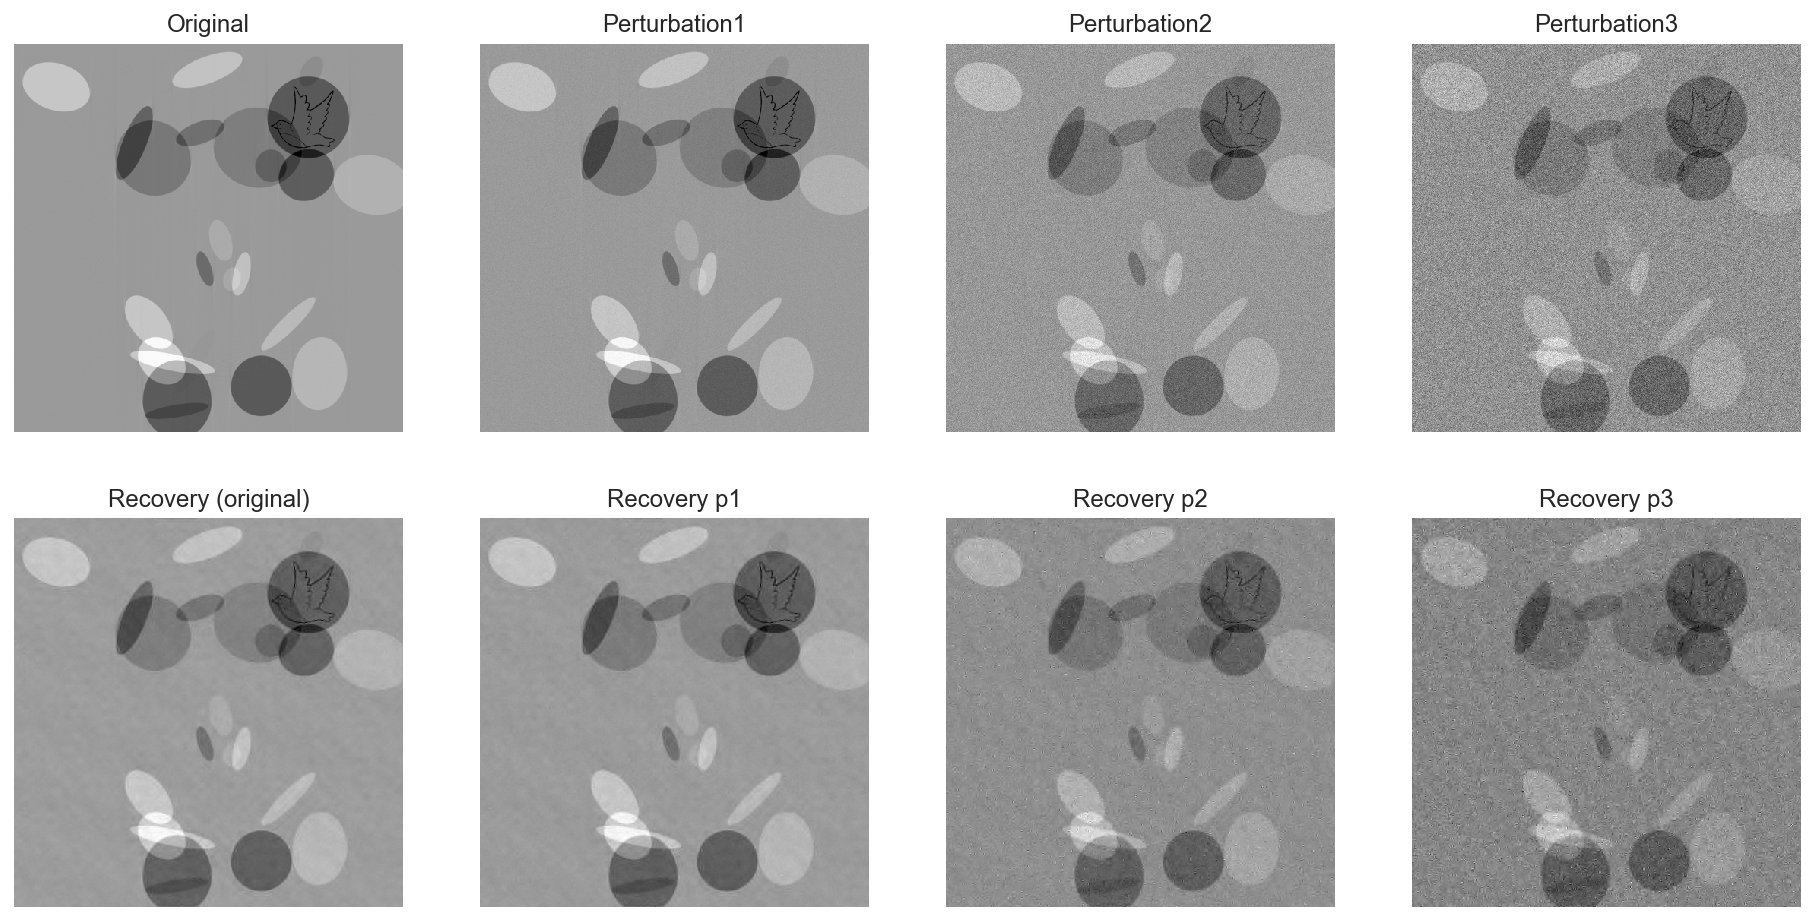

In [24]:
# Graphics
plt.figure(figsize = (16,8))

plt.subplot(241)
imageplot(im, 'Original')

plt.subplot(242)
imageplot(im1, 'Perturbation1')

plt.subplot(243)
imageplot(im2, 'Perturbation2')

plt.subplot(244)
imageplot(im3, 'Perturbation3')

plt.subplot(245)
imageplot(rec_trans30, 'Recovery (original)')

plt.subplot(246)
imageplot(rec_trans31, 'Recovery p1')

plt.subplot(247)
imageplot(rec_trans32, 'Recovery p2')

plt.subplot(248)
imageplot(rec_trans33, 'Recovery p3')

As expected, similar satisfactory results are obtained in terms of stability and robustness. This is due to the central property of **Kernel Awareness** ie. constructing a sensing matrix $A$ with a null space that does not contain any s-sparse vector apart from the null vector. This property is satisfied once the sensing matrix satisfies RIP. 

Kernel awareness is then at the heart of Compressed Sensing, unlike Neural Networks for which the learning procedure encourages having two well-reconstructed vectors whose difference lies close (or in) the null space of $A$, making it very unstable.

# References
___

Nina M. Gottschling, Vegard Antun, Ben Adcock andAnders C. Hansen. The troublesome kernel: why deep learning for inverse problems is typically unstable. Proceedings of the National Academy of Sciences 117 (48), 30088-30095, 2020.

S. Foucart and H. Rauhut. A mathematical introduction to Compressive Sensing. Birkhauser, 2013.

V. Antun, F. Renna, C. Poon, B. Adcock, and A. C. Hansen. On instabilities of deep learning in image reconstruction – does AI come at a cost. arXiv preprint arXiv:1902.05300, 2019. 

Y. Huang, T. Wu ̈rfl, K. Breininger, L. Liu, G. Lauritsch, and A. Maier. Some investigations on robustness of deep learning in limited angle tomography. In Int. Conf. on Medical Image Computing and Computer-Assisted Intervention, pages 145–153. Springer, 2018. 